In [1]:
import numpy as np
from osgeo import gdal
from rasterio import features
import geopandas as gpd
from shapely.geometry import mapping
from affine import Affine
import os
import re
from util.misc import saveraster
from pet_calc import calculate_PET_grid
# tmrt_by_time = {}
#
# # Regex pattern to extract time (HHMM) from filename
# pattern = re.compile(r'^Tmrt_\d{4}_\d{3}_(\d{4})D\.tif$')
#
# # Loop through files and extract time
# for filename in os.listdir(solweig_folder):
#     match = pattern.match(filename)
#     if match:
#         time_str = match.group(1)  # e.g., "0918"
#         full_path = os.path.join(solweig_folder, filename)
#         tmrt_by_time[time_str] = full_path
#
# # Print the dictionary
# for time, path in sorted(tmrt_by_time.items()):
#     print(f"{time}: {path}")

buildings_path = "D:/Geomatics/thesis/heattryout/buildings.gpkg"
tmrt_path = "D:/Geomatics/thesis/heattryout/output/Tmrt_2016_184_1400D.tif"

In [2]:
from pet_calc import calculate_PET_grid

In [53]:
class Pet:
    def __init__(self,mbody=70, age=35, height=175, activity=80.0, sex=1, clo=1):
        self.mbody = mbody
        self.age = age
        self.height = height
        self.activity = activity
        self.sex = sex
        self.clo = clo

In [54]:

pet = Pet()
mrt = np.array([[10], [50]]) * np.ones((2, 7))
wind = np.full((2, 7), 0.1)
airtemp = np.tile(np.array([40, 39, 38, 37, 36, 35, 34]), (2, 1))

hum = np.full((2, 7), 80)


Ta_array = (airtemp if isinstance(airtemp, np.ndarray) else np.full_like(mrt, airtemp)).astype(np.float64)
RH_array = (hum if isinstance(hum, np.ndarray) else np.full_like(mrt, hum)).astype(np.float64)
va_array = (wind if isinstance(wind , np.ndarray) else np.full_like(mrt, wind )).astype(np.float64)
Tmrt = mrt.astype(np.float64)

In [55]:
grid = calculate_PET_grid(Ta_array, RH_array, Tmrt, va_array, pet)

In [56]:
print(grid)

[[25.849 25.319 24.789 24.369 24.269 23.91  23.459]
 [46.421 45.941 45.471 44.991 44.511 44.042 43.561]]


In [1]:
import numpy as np
import h5py

In [2]:
from rasterio.features import geometry_mask, shapes
from shapely.geometry import shape,box
class TmrtOutput:
    def __init__(self, output_folder, building_data=None, buildings_path=None, layer=None):
        self.output_folder = output_folder
        self.building_data = building_data
        self.buildings_path = buildings_path
        self.gdal_dataset = None
        self.layer = layer
        self.building_mask = self.create_building_mask()

        self.tmrt_arrays_by_time = self.calc_arrays(output_folder)
        self.time_groups = self.group_by_time_of_day()
        self.averaged_tmrt = self.average_time_groups()

        self.pet_arrays_by_time = None
        self.time_pet_groups = None
        self.averaged_tmrt = None

    @staticmethod
    def get_pet_raster_from_lookup(tmrt_raster, wind_speed, air_temp, rh, body_type, lookup_file):
        with h5py.File(lookup_file, "r") as f:
            pet_dataset = f[body_type]

            wind_speeds = np.array([0.1, 2.0, 6.0])
            rhs = np.arange(100, -1, -20)
            tmrts = np.arange(65, -1, -1)
            temps = np.arange(40, -1, -1)

            def find_nearest_index(array, value):
                return np.abs(array - value).argmin()

            ws_idx = find_nearest_index(wind_speeds, wind_speed)
            rh_idx = find_nearest_index(rhs, rh)
            ta_idx = find_nearest_index(temps, air_temp)

            # Clamp and map tmrt values to lookup indices (reversed axis)
            tmrt_clipped = np.clip(tmrt_raster, 0, 65)
            tmrt_rounded = np.round(tmrt_clipped).astype(int)  # Round to nearest integer

            # Map tmrt values to lookup indices (reversed axis)
            tmrt_indices = 65 - tmrt_rounded

            pet_raster = np.take(pet_dataset[ws_idx, rh_idx, :, ta_idx], tmrt_indices)
            return pet_raster

    def create_building_mask(self):
        """Create building mask using the first matching TMRT file"""
        pattern = re.compile(r'^Tmrt_\d{4}_\d{3}_(\d{4})D\.tif$')

        first_tmrt_file = None
        for filename in os.listdir(self.output_folder):
            if pattern.match(filename):
                first_tmrt_file = os.path.join(self.output_folder, filename)
                break

        if not first_tmrt_file:
            print("No TMRT .tif files found in the folder.")
            return None

        self.gdal_dataset = gdal.Open(first_tmrt_file)

        if self.building_data is not None:
            building_shapes = [shape(b['geometry']) for b in self.building_data if 'geometry' in b]
        else:
            gdf = gpd.read_file(self.buildings_path, layer=self.layer)
            building_shapes = [geom for geom in gdf.geometry]

        transform = Affine.from_gdal(*self.gdal_dataset.GetGeoTransform())
        raster_shape = self.gdal_dataset.GetRasterBand(1).ReadAsArray().shape

        mask = features.rasterize(
            ((mapping(geom), 1) for geom in building_shapes),
            out_shape=raster_shape,
            transform=transform,
            fill=0,
            dtype=np.uint8
        )

        return mask


    def calc_arrays(self, output_folder):
        tmrt_arrays_by_time = {}

        pattern = re.compile(r'^Tmrt_\d{4}_\d{3}_(\d{4})D\.tif$')

        for filename in os.listdir(output_folder):
            match = pattern.match(filename)
            if match:
                time_key = match.group(1)
                file_path = os.path.join(output_folder, filename)

                # Open file using gdal
                dataset = gdal.Open(file_path)
                if dataset is None:
                    print(f"Could not open {file_path}")
                    continue

                band = dataset.GetRasterBand(1)
                array = band.ReadAsArray()

                masked_array = np.where(self.building_mask == 1, np.nan, array)

                tmrt_arrays_by_time[time_key] = masked_array

        return tmrt_arrays_by_time

    def get_time_group(self, time_str):
        time_val = int(time_str)
        if 600 <= time_val < 1200:
            return 'morning'
        elif 1200 <= time_val < 1800:
            return 'afternoon'
        elif 1800 <= time_val <= 2100:
            return 'evening'
        return None

    def group_by_time_of_day(self):
        grouped = {'morning': [], 'afternoon': [], 'evening': []}

        for time_str, array in self.tmrt_arrays_by_time.items():
            group = self.get_time_group(time_str)
            if group:
                grouped[group].append(array)

        return grouped

    def average_time_groups(self):
        avg_by_group = {}
        for group, arrays in self.time_groups.items():
            if arrays:
                stacked = np.stack(arrays)
                avg = np.mean(stacked, axis=0)
                avg_by_group[group] = avg
            else:
                avg_by_group[group] = None
        return avg_by_group

    def calculate_stats_and_bins(self, array, pixel_size=0.5, isTmrt=True):
        if isTmrt:
            bins = [-np.inf, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
        else:
            bins = [-np.inf, 4, 8, 13, 18, 23, 29, 35, 41, np.inf]
        masked = array[~np.isnan(array)]

        stats = {
            'mean': np.nanmean(array),
            'median': np.nanmedian(array),
            'min': np.nanmin(array),
            'max': np.nanmax(array),
        }

        hist, bin_edges = np.histogram(masked, bins=bins)
        pixel_area = pixel_size ** 2
        bin_areas = hist * pixel_area
        total_area = np.sum(bin_areas)
        bin_percentages = (bin_areas / total_area) * 100

        stats['bins'] = [
            {
                'range': (bin_edges[i], bin_edges[i + 1]),
                'area_m2': bin_areas[i],
                'percentage': bin_percentages[i]
            }
            for i in range(len(hist))
        ]

        return stats

    def calc_pet(self, Ta, RH, va, body_type="standard_man", lookup_file="pet_lookup.h5"):
        """
        Compute PET array for the 1300 TMRT time step using precomputed PET lookup.
        Inputs:
            Ta: Air temperature in °C (scalar)
            RH: Relative humidity in % (scalar)
            va: Wind speed in m/s (scalar)
            body_type: One of "standard_man", "elderly_woman", "young_child"
            lookup_file: Path to PET HDF5 lookup file
        """
        self.pet_arrays_by_time = {}

        Tmrt = self.tmrt_arrays_by_time.get("1300")
        if Tmrt is None:
            raise ValueError("1300 time step not found in Tmrt data.")

        # Compute PET raster from lookup
        pet_array = self.get_pet_raster_from_lookup(Tmrt, va, Ta, RH, body_type, lookup_file)
        self.pet_arrays_by_time["1300"] = pet_array

In [8]:
np.array

<function numpy.array>

In [9]:
numpy_version = np.__version__
print(numpy_version)

1.26.4


In [10]:
# Define your folder path
solweig_folder = "E:/Geomatics/thesis/heattryout/output"
buildings_path = "E:/Geomatics/thesis/heattryout/buildings.gpkg"

tmrt = TmrtOutput(solweig_folder, buildings_path=buildings_path, layer='lod13')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:/Geomatics/thesis/heattryout/output'

In [7]:
pet_model = Pet()

In [8]:
va = np.zeros_like(tmrt.tmrt_arrays_by_time["1600"])
va += 1.0

In [9]:
tmrt.calc_pet(20, 90, va, pet_model)

In [10]:
import matplotlib.pyplot as plt
def plot_raster(array, title="DSM original"):
    plt.figure(figsize=(10, 8), facecolor="white")
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.imshow(array, cmap="viridis", origin="upper", vmin=0, vmax=50)
    plt.colorbar(label="Elevation (m)")
    plt.title(title)
    plt.show()

In [11]:
print(tmrt.pet_arrays_by_time["1300"].shape)

(532, 580)


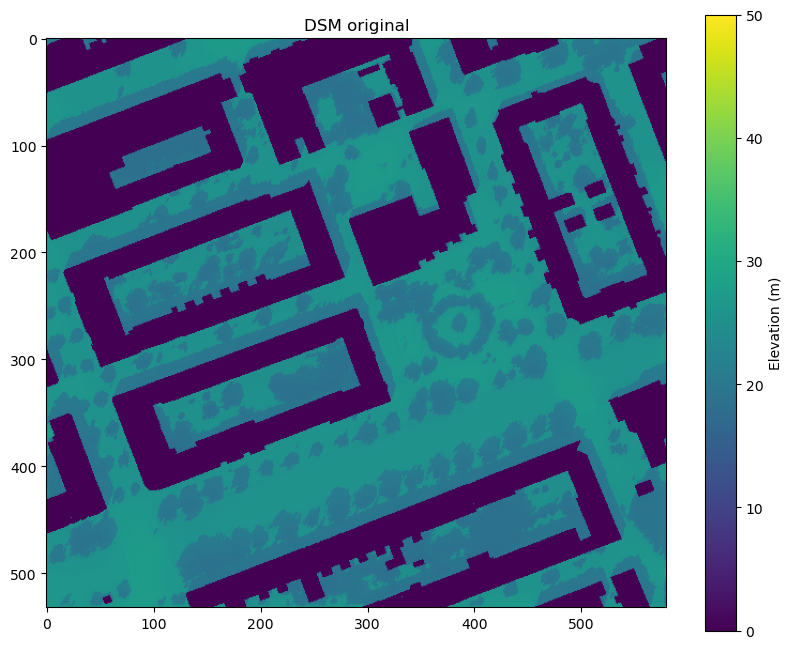

In [12]:
plot_raster(tmrt.pet_arrays_by_time["1300"])

In [13]:
from util.misc import saveraster
saveraster(tmrt.gdal_dataset, "pet_test_wind_cython_1.0.tiff", tmrt.pet_arrays_by_time["1300"])


In [14]:
print(tmrt.pet_arrays_by_time)

{'1300': array([[   26.721,    21.151,    20.881, ..., -9999.   , -9999.   ,
        -9999.   ],
       [   26.311,    20.961,    20.371, ..., -9999.   , -9999.   ,
        -9999.   ],
       [   26.044,    20.661,    20.042, ..., -9999.   , -9999.   ,
        -9999.   ],
       ...,
       [   26.621,    26.571,    26.571, ...,    21.281,    26.391,
           26.711],
       [   26.691,    26.631,    26.671, ...,    26.371,    26.581,
           26.991],
       [   26.711,    26.851,    26.781, ...,    26.641,    26.911,
           27.181]], shape=(532, 580))}


In [15]:
for i in tmrt.tmrt_arrays_by_time:
    print(i)

0400
0500
0600
0700
0800
0900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [16]:
tmrt.calculate_stats_and_bins(tmrt.averaged_tmrt['morning'])

TypeError: 'NoneType' object is not subscriptable

In [16]:
buildings_gdf = gpd.read_file(buildings_path, layer="lod13")
buildings = [{"geometry": mapping(geom)} for geom in buildings_gdf.geometry]

In [5]:
gdal_tmrt = gdal.Open(tmrt_path)
mrt_raster = gdal_tmrt.ReadAsArray()

In [16]:
# Get raster georeferencing info
transform = Affine.from_gdal(*gdal_tmrt.GetGeoTransform())
pixel_size_x = 0.5
pixel_size_y = 0.5
raster_shape = mrt_raster.shape

# Rasterize buildings to mask
building_shapes = [mapping(geom) for geom in buildings_gdf.geometry]
mask = features.rasterize(
    ((geom, 1) for geom in building_shapes),
    out_shape=raster_shape,
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Apply mask (set building areas to nan)
masked_raster = np.where(mask == 1, np.nan, mrt_raster)

# Calculate stats ignoring nan
mean_val = np.nanmean(masked_raster)
median_val = np.nanmedian(masked_raster)
min_val = np.nanmin(masked_raster)
max_val = np.nanmax(masked_raster)

# Bin data
bins = [-np.inf, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
hist, bin_edges = np.histogram(masked_raster[~np.isnan(masked_raster)], bins=bins)

# Calculate area of each bin (assuming square pixels)
pixel_area = pixel_size_x * pixel_size_y  # in map units, e.g., m²
bin_areas = hist * pixel_area

# Print results
print("Temperature Statistics (excluding buildings):")
print(f"Mean: {mean_val:.2f}, Median: {median_val:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

print("\nTemperature Bins (°C) and Area (m²):")
for i in range(len(hist)):
    print(f"{bin_edges[i]}–{bin_edges[i+1]} °C: {bin_areas[i]:.2f} m²")

Temperature Statistics (excluding buildings):
Mean: 30.44, Median: 35.33, Min: 18.41, Max: 44.85

Temperature Bins (°C) and Area (m²):
-inf–15.0 °C: 0.00 m²
15.0–20.0 °C: 1330.50 m²
20.0–25.0 °C: 20588.00 m²
25.0–30.0 °C: 1588.00 m²
30.0–35.0 °C: 816.75 m²
35.0–40.0 °C: 23823.50 m²
40.0–45.0 °C: 1779.25 m²
45.0–50.0 °C: 0.00 m²
50.0–inf °C: 0.00 m²


In [13]:
import matplotlib.pyplot as plt
def plot_raster(array, title="DSM original"):
        plt.figure(figsize=(10, 8), facecolor="white")
        ax = plt.gca()
        ax.set_facecolor("white")
        plt.imshow(array, cmap="viridis", origin="upper")
        plt.colorbar(label="Elevation (m)")
        plt.title(title)
        plt.show()

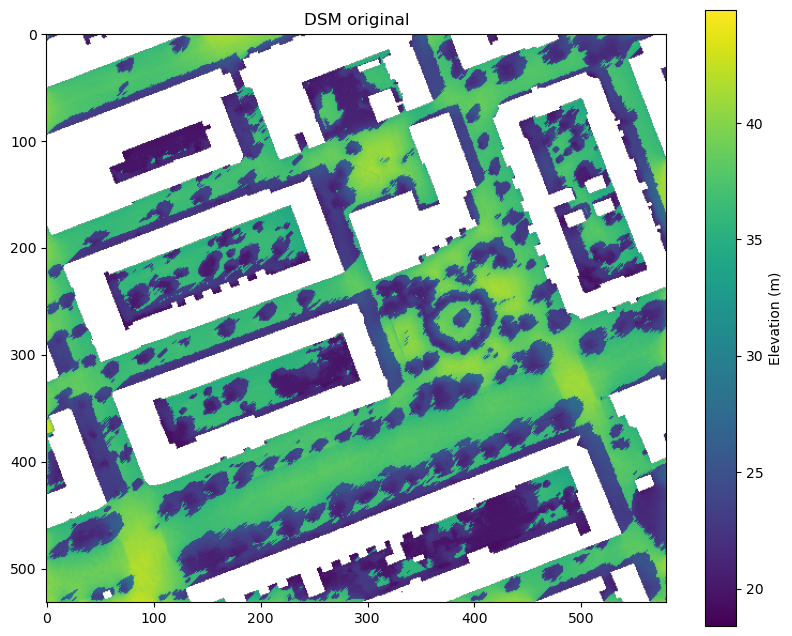

In [14]:
plot_raster(masked_raster)